## This notebook aims to give the most likely pitch type for all of the pitches in the test dataset using information from the training dataset. The predicted pitch types can be found in the file pitchtypes.csv.

### Nolan McCafferty

#### Import necessary libraries

In [111]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import collections  as mc
import xgboost as xgb
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

#### Read in the training data and split into training and validation

In [4]:
pitch_data = pd.read_csv('pitchclassificationtrain.csv')
train_x, validate_x, train_y, validate_y = train_test_split(pitch_data.drop(['pitchid','type'], axis=1),
pitch_data['type'], train_size=0.8)

### Here is a sample of the data:

In [137]:
pitch_data[1:10]

,pitchid,pitcherid,yearid,height,initspeed,breakx,breakz,initposx,initposz,extension,spinrate,type
1,2,5,1,72,89.642714,-6.550556,7.993455,-1.556463,5.719125,6.119526,1963.264977,9
2,3,4,1,72,91.750648,-6.985574,8.991264,-2.055134,5.780312,6.201200,2360.758263,9
3,4,5,1,72,83.189766,-2.549204,4.844714,-1.001020,6.240138,6.074156,858.997788,7
4,5,2,1,80,92.698738,-5.216516,7.267769,-2.097643,5.776138,6.212281,2060.155099,9
5,6,2,1,80,93.465101,-3.705180,9.575830,-2.412097,5.930423,6.362127,2150.557826,10
6,7,5,1,72,90.133351,-3.457456,9.394351,-1.712198,5.878997,6.315298,2070.610056,10
7,8,2,1,80,94.988449,-0.475622,9.409168,-1.708333,6.168799,6.565337,2254.638912,10
8,9,5,1,72,90.934010,-1.173693,7.685287,-1.005594,5.963014,5.986846,1740.423250,10
9,10,4,1,72,87.374464,1.512633,4.563257,-2.331637,5.982525,6.225165,2442.328132,8


#### Read in the test data

In [5]:
test_data = pd.read_csv('pitchclassificationtest.csv')
test_x = test_data.drop(['pitchid'], axis=1)

### Initial exploration of the data 

#### An initial plot of velocity vs spin rate reveals several clusters corresponding to the different pitch types. From the plot below, I can conclude that the yellow dots (pitch type 10) are fastballs, unless one of these pitchers throws a triple digit off speed pitch which I would love to see. 

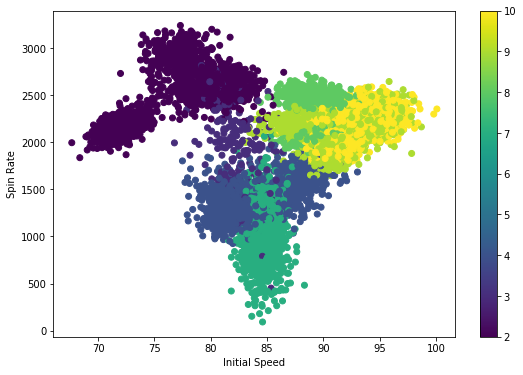

In [26]:
plt.rcParams['figure.figsize'] = [9, 6]
plt.scatter(pitch_data['initspeed'], pitch_data['spinrate'], c=pitch_data['type']);
plt.colorbar();
plt.xlabel('Initial Speed');
plt.ylabel('Spin Rate');

#### The plot below shows the final positions of the pitches, again revealing clusters of pitch types. The dark purple cluster (pitch type 2) seems to be focused low and away to righties, leading me to believe it could be a slider. 

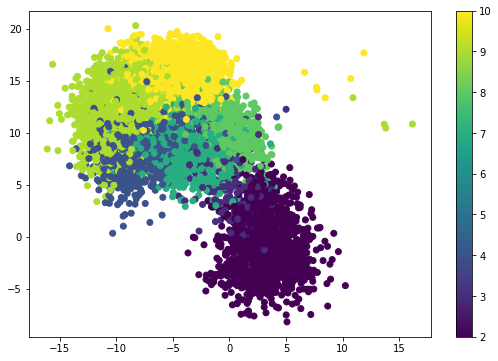

In [135]:
plt.scatter(pitch_data['initposx'] + pitch_data['breakx'], pitch_data['initposz'] + pitch_data['breakz'], 
            c=pitch_data['type']);
plt.colorbar();

#### Fit a multinomial logistic regression model to the training data and use the validation data to check accuracy

In [60]:
model = LogisticRegression(multi_class='multinomial', solver='newton-cg', random_state=7).fit(train_x, train_y)
model.score(validate_x, validate_y)

0.9183098591549296

### Lets try another model

#### Fit a random forest classification model to the training data and use the validation data to check accuracy. The hyperparamters were tuned to achieve maximum score on validation data. 

In [69]:
modelrandom = RandomForestClassifier(n_estimators=100, max_features=2, random_state=7).fit(train_x, train_y)
modelrandom.score(validate_x, validate_y)

0.9314553990610329

#### The two models give almost identical accuracy scores for predicting the validation data, with the random forest model slightly edging out logistic regression. From the random forest model, we can see how much each variable affected the predictions:

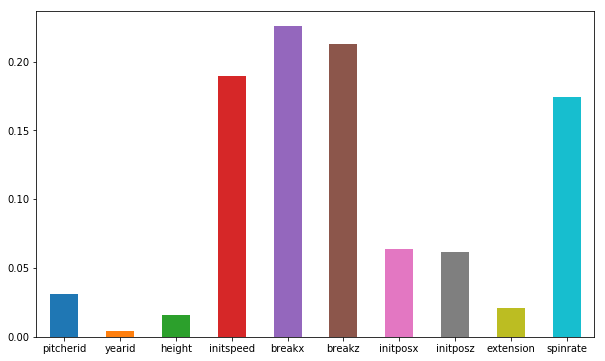

In [62]:
feature_importances = pd.Series(modelrandom.feature_importances_, index=train_x.columns)
feature_importances.sort_values()
feature_importances.plot(kind='bar', figsize=(10,6))
plt.xticks(rotation='horizontal');

#### From the plot above, we see that the most infuencial variable was breakx, followed by initial speed, breakz, and spin rate, which makes sense because those are typically the things that differ most between different pitch types. 

### Predict test data

In [267]:
predictions = modelrandom.predict(test_x)

12354

#### Create data frame of predictions

In [277]:
data = {'pitchid': test_data['pitchid'], 'predicted_type': predictions}
df = pd.DataFrame(data)
df[:10]

,pitchid,predicted_type
0,10648,10
1,10649,9
2,10650,9
3,10651,10
4,10652,10
5,10653,4
6,10654,10
7,10655,10
8,10656,9
9,10657,9


#### Write predictions to file

In [280]:
df.to_csv('pitch_predictions.csv')